# Predicting Client Churn with TensorFlow

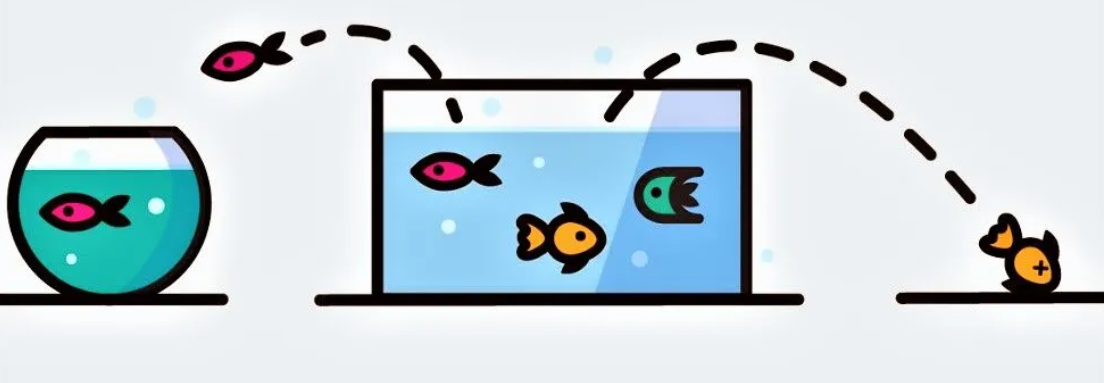
#### Churn is the departure of customers from a product or service, measured as the percentage discontinuing within a period. It's a critical business metric, impacting revenue. To counteract this, businesses employ predictive modeling and analysis to identify factors associated with churn, enabling proactive retention strategies.

********************************************************************************************************************************************************

## 1. Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score

# Set the global random seed
tf.random.set_seed(42)
# Set the NumPy random seed (used by Keras backend)
np.random.seed(42)

In [2]:
df = pd.read_csv('churn_data.csv')
print(len(df))

7044


There are **`7044`** data points in the dataset

In [3]:
df.head(1)

,Customer ID,Gender,Senior Citizen,Partner,Dependents,tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,7590-VHVEA,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


The Churn column will be our **target** variable *y* for training the model.

In [4]:
X = pd.get_dummies(df.drop(['Churn'], axis=1))
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [5]:
X.head(1)

,Senior Citizen,tenure,Monthly Charges,Customer ID_0002-ORFBO,Customer ID_0003-MKNFE,Customer ID_0004-TLHLJ,Customer ID_0011-IGKFF,Customer ID_0013-EXCHZ,Customer ID_0013-MHZWF,Customer ID_0013-SMEOE,...,Total Charges_995.35,Total Charges_996.45,Total Charges_996.85,Total Charges_996.95,Total Charges_997.65,Total Charges_997.75,Total Charges_998.1,Total Charges_999.45,Total Charges_999.8,Total Charges_999.9
0,0,1,29.85,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


There are **`13619`** one-hot encoded features! Let's see what features may be creating a larger training
dataset than necessary

In [6]:
def top_5_unique_features(dataframe):
    # Flatten the DataFrame into a list of tuples (column_name, value)
    flat_list = [(column, len(df[column].unique())) for column in df.columns]
    
    # Sort the list of tuples by the second element (value)
    sorted_list = sorted(flat_list, key=lambda x: x[1], reverse=True)
    
    # Get the top 5 items and their corresponding column names
    top_5_items = sorted_list[:5]
    
    return top_5_items

In [7]:
top_5_unique_features(df)

[('Customer ID', 7044),
 ('Total Charges', 6531),
 ('Monthly Charges', 1585),
 ('tenure', 73),
 ('Payment Method', 4)]

We can see that **Customer ID**, **Total Charges**, and **Monthly Charges** have many different values. Lets remove these from the dataset and re-encode.

In [8]:
X = pd.get_dummies(df.drop(['Churn', 'Customer ID', 'Total Charges', 'Monthly Charges'], axis=1))
X.head(1)

,Senior Citizen,tenure,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone Service_No,Phone Service_Yes,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,1,True,False,False,True,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False


Much Better! There are now only **`43`** features to train the model with. Go ahead and split the data leaving 20% for testing

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## 2. Building and Compiling

In a **`Dense`** layer, each neuron is connected to every neuron in the previous layer. If the Dense layer is the first layer in a neural network, it receives input directly from the input data.

* **units**	Positive integer, dimensionality of the output space
* **activation** Rectified Linear Unit (*relu*), is zero for any negative input and is equal to the input for any positive input. The sigmoid activation function (*sigmoid*) is commonly used in the output layer for binary classification problems
* **input_dim** Each row should have this many features
* **kernel_regularizer** Regularizer function applied to the kernel weights matrix. *l1* = 'Lasso' and *l2* = 'Ridge', are tunable hyperparameters

In [10]:
model = Sequential()

**`First Layer`** this layer is a fully connected layer with 32 neurons, using the ReLU activation function, taking input from a dataset with a number of features specified by input_dim, and applying L1 regularization to the weights with a penalty of 0.01:

In [11]:
model.add(Dense(units=32, activation='relu', input_dim = len(X_train.columns), kernel_regularizer=regularizers.l1
(0.01)))

**`Second Layer`** this layer is a fully connected layer with 64 neurons, using the ReLU activation function,
and applying L2 regularization to the weights with a penalty of 0.01:

In [12]:
model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

**`Output Layer`** this layer is a fully connected layer with a single neuron, and the output of this neuron is transformed using the sigmoid activation function

In [13]:
model.add(Dense(units=1, activation='sigmoid'))

**`Compiling`** The model is configured for binary classification tasks, aiming to minimize the binary crossentropy loss using Stochastic Gradient Descent (SGD) as the optimization algorithm during training. The model's performance will be assessed using the accuracy metric, indicating the proportion of correct predictions in the target class.

In [14]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')

## 3. Fitting and Predicting

This code is instructing the model to train on the provided training data (X_train and y_train) for 200 epochs (one complete pass through the entire training dataset during the training phase), updating its parameters after processing each batch of 32 examples. The training history, including metrics like loss and accuracy over each epoch, is stored in the history variable

In [15]:
%%time
X_train = tf.convert_to_tensor(X_train, dtype = tf.float32)
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
177/177 [==============================] - 1s 2ms/step - loss: 2.8004 - accuracy: 0.7613
Epoch 2/100
177/177 [==============================] - 0s 2ms/step - loss: 2.5173 - accuracy: 0.7837
Epoch 3/100
177/177 [==============================] - 0s 2ms/step - loss: 2.2667 - accuracy: 0.7888
Epoch 4/100
177/177 [==============================] - 0s 2ms/step - loss: 2.0466 - accuracy: 0.7858
Epoch 5/100
177/177 [==============================] - 0s 2ms/step - loss: 1.8346 - accuracy: 0.7874
Epoch 6/100
177/177 [==============================] - 0s 2ms/step - loss: 1.6377 - accuracy: 0.7915
Epoch 7/100
177/177 [==============================] - 1s 3ms/step - loss: 1.4634 - accuracy: 0.7954
Epoch 8/100
177/177 [==============================] - 1s 3ms/step - loss: 1.3066 - accuracy: 0.7913
Epoch 9/100
177/177 [==============================] - 1s 3ms/step - loss: 1.1728 - accuracy: 0.7894
Epoch 10/100
177/177 [==============================] - 0s 3ms/step - loss: 1.0485 - accura

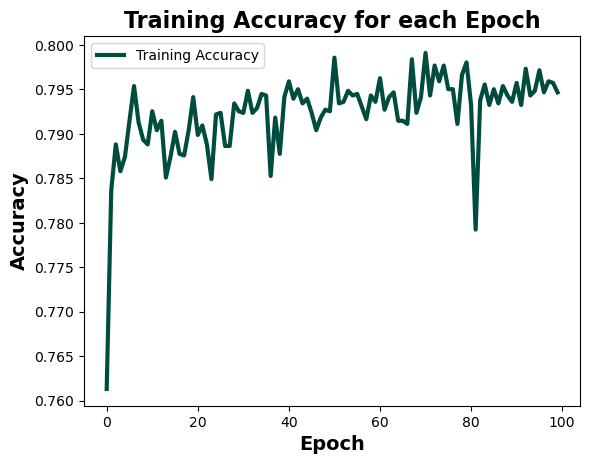

In [16]:
plt.plot(history.history['accuracy'], label='Training Accuracy', c='#004D40', linewidth=3)
plt.title('Training Accuracy for each Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

In [17]:
print(f"The maximum score during training was {np.round(max(history.history['accuracy']), 3)}")

The maximum score during training was 0.799


In [18]:
X_test = tf.convert_to_tensor(X_test, dtype = tf.float32)
y_hat = model.predict(X_test)
y_hat = [0 if value < 0.5 else 1 for value in y_hat]

45/45 [==============================] - 0s 2ms/step


In [19]:
print(f"The validation score for the model is {np.round(accuracy_score(y_test, y_hat), 3)}")

The validation score for the model is 0.799


## 4. Saving and Reloading

In [20]:
model.save('saved_tf_model')

INFO:tensorflow:Assets written to: saved_tf_model\assets


Delete the model and reload the version saved in memory

In [21]:
del model

In [22]:
reloaded_model = load_model('saved_tf_model')

In [23]:
def predict_one_observation(labeled_row, model):
    new_predict = model.predict(labeled_row)
    print(['No Churn Expected for this client' if value < 0.5 else 'Yes, Churn Expected for this client' for value in new_predict][0])

In [24]:
important_client_data = tf.convert_to_tensor(X.iloc[[40]], dtype = tf.float32)
predict_one_observation(important_client_data, reloaded_model)

1/1 [==============================] - 0s 72ms/step
Yes, Churn Expected for this client
